In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.__version__

'0.12.0'

In [3]:
pd.__version__

'1.3.4'

In [4]:
#perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240612/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_fnn_2l_lr1e-4/aligned_msl2048/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [5]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        df["orig_y_pred"] = orig_pred_class
        df["new_y_pred"] = df[classes].idxmax(axis=1)
    
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [6]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [7]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [8]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2978369, 17)



#### WIV04 reference sequence

In [9]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [10]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [11]:
wiv04_aligned_seq[:2049]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [12]:
wiv04_aligned_seq[2049:]

'KVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFC-GKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---------HDGKAHFPRE---GVFVS-----NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPEL----DSFKEELDKYFKNHTSPDVDLGDIS-GINASV--VNIQKEID--------------RLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCMTS-----CCS-----------CLKG------------CCSCGSCCKFD-----------EDDSEPVLKGVKLHYT--'

In [13]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [14]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.000021,0.000408,0.023282,0.000002,0.000056,0.000034,0.944711,0.031486,UniRef90_A0A7T6Y5W2,Human,E,2309,Y,0.000000,0.000000,Human,Human,1207
1,0.000021,0.000416,0.023190,0.000002,0.000055,0.000033,0.945324,0.030958,UniRef90_A0A7T6Y5W2,Human,G,1502,C,0.000613,0.000613,Human,Human,545
2,0.000022,0.000392,0.023945,0.000002,0.000057,0.000035,0.944159,0.031387,UniRef90_A0A7T6Y5W2,Human,X,271,D,-0.000552,0.000552,Human,Human,128
3,0.000021,0.000405,0.023336,0.000002,0.000056,0.000034,0.944569,0.031576,UniRef90_A0A7T6Y5W2,Human,V,1448,E,-0.000142,0.000142,Human,Human,524
4,0.000021,0.000408,0.023282,0.000002,0.000056,0.000034,0.944711,0.031486,UniRef90_A0A7T6Y5W2,Human,Y,2131,M,0.000000,0.000000,Human,Human,1067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,0.000017,0.000386,0.019120,0.000002,0.000047,0.000023,0.953430,0.026975,UniRef90_A0A8B1K2U2,Human,G,1899,J,0.000024,0.000024,Human,Human,857
31822,0.000017,0.000386,0.019142,0.000002,0.000047,0.000023,0.953347,0.027035,UniRef90_A0A8B1K2U2,Human,S,1669,B,-0.000059,0.000059,Human,Human,673
31823,0.000017,0.000387,0.019109,0.000002,0.000047,0.000023,0.953406,0.027009,UniRef90_A0A8B1K2U2,Human,K,2408,U,0.000000,0.000000,Human,Human,1266
31824,0.000017,0.000387,0.018995,0.000002,0.000047,0.000023,0.953848,0.026683,UniRef90_A0A8B1K2U2,Human,F,1519,C,0.000441,0.000441,Human,Human,562


In [15]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [16]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.000021,0.000408,0.023282,0.000002,0.000056,0.000034,0.944711,0.031486,UniRef90_A0A7T6Y5W2,Human,E,2309,Y,0.000000,0.000000,Human,Human,1207
1,0.000021,0.000416,0.023190,0.000002,0.000055,0.000033,0.945324,0.030958,UniRef90_A0A7T6Y5W2,Human,G,1502,C,0.000613,0.000613,Human,Human,545
2,0.000022,0.000392,0.023945,0.000002,0.000057,0.000035,0.944159,0.031387,UniRef90_A0A7T6Y5W2,Human,X,271,D,-0.000552,0.000552,Human,Human,128
3,0.000021,0.000405,0.023336,0.000002,0.000056,0.000034,0.944569,0.031576,UniRef90_A0A7T6Y5W2,Human,V,1448,E,-0.000142,0.000142,Human,Human,524
4,0.000021,0.000408,0.023282,0.000002,0.000056,0.000034,0.944711,0.031486,UniRef90_A0A7T6Y5W2,Human,Y,2131,M,0.000000,0.000000,Human,Human,1067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,0.000017,0.000386,0.019120,0.000002,0.000047,0.000023,0.953430,0.026975,UniRef90_A0A8B1K2U2,Human,G,1899,J,0.000024,0.000024,Human,Human,857
31822,0.000017,0.000386,0.019142,0.000002,0.000047,0.000023,0.953347,0.027035,UniRef90_A0A8B1K2U2,Human,S,1669,B,-0.000059,0.000059,Human,Human,673
31823,0.000017,0.000387,0.019109,0.000002,0.000047,0.000023,0.953406,0.027009,UniRef90_A0A8B1K2U2,Human,K,2408,U,0.000000,0.000000,Human,Human,1266
31824,0.000017,0.000387,0.018995,0.000002,0.000047,0.000023,0.953848,0.026683,UniRef90_A0A8B1K2U2,Human,F,1519,C,0.000441,0.000441,Human,Human,562


# Overview

### Distribution of Human class difference

In [17]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [18]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 674 (0.02282487260910306)
Distribution of full perturbation output
n=2952919
       start       end    count  percentage
0  -0.221307 -0.183833       33    0.001118
1  -0.183833 -0.146359       93    0.003149
2  -0.146359 -0.108885       92    0.003116
3  -0.108885 -0.071411      329    0.011142
4  -0.071411 -0.033937      943    0.031935
5  -0.033937  0.003537  2936050   99.428735
6   0.003537  0.041011    14607    0.494663
7   0.041011  0.078485      303    0.010261
8   0.078485  0.115959      105    0.003556
9   0.115959  0.153433       89    0.003014
10  0.153433  0.190908       61    0.002066
11  0.190908  0.228382       37    0.001253
12  0.228382  0.265856       35    0.001185
13  0.265856  0.303330       20    0.000677
14  0.303330  0.340804       69    0.002337
15  0.340804  0.378278       23    0.000779
16  0.378278  0.415752       18    0.000610
17  0.415752  0.453226        3    0.000102
18  0.453226  0.490700        6   

<Figure size 432x288 with 0 Axes>

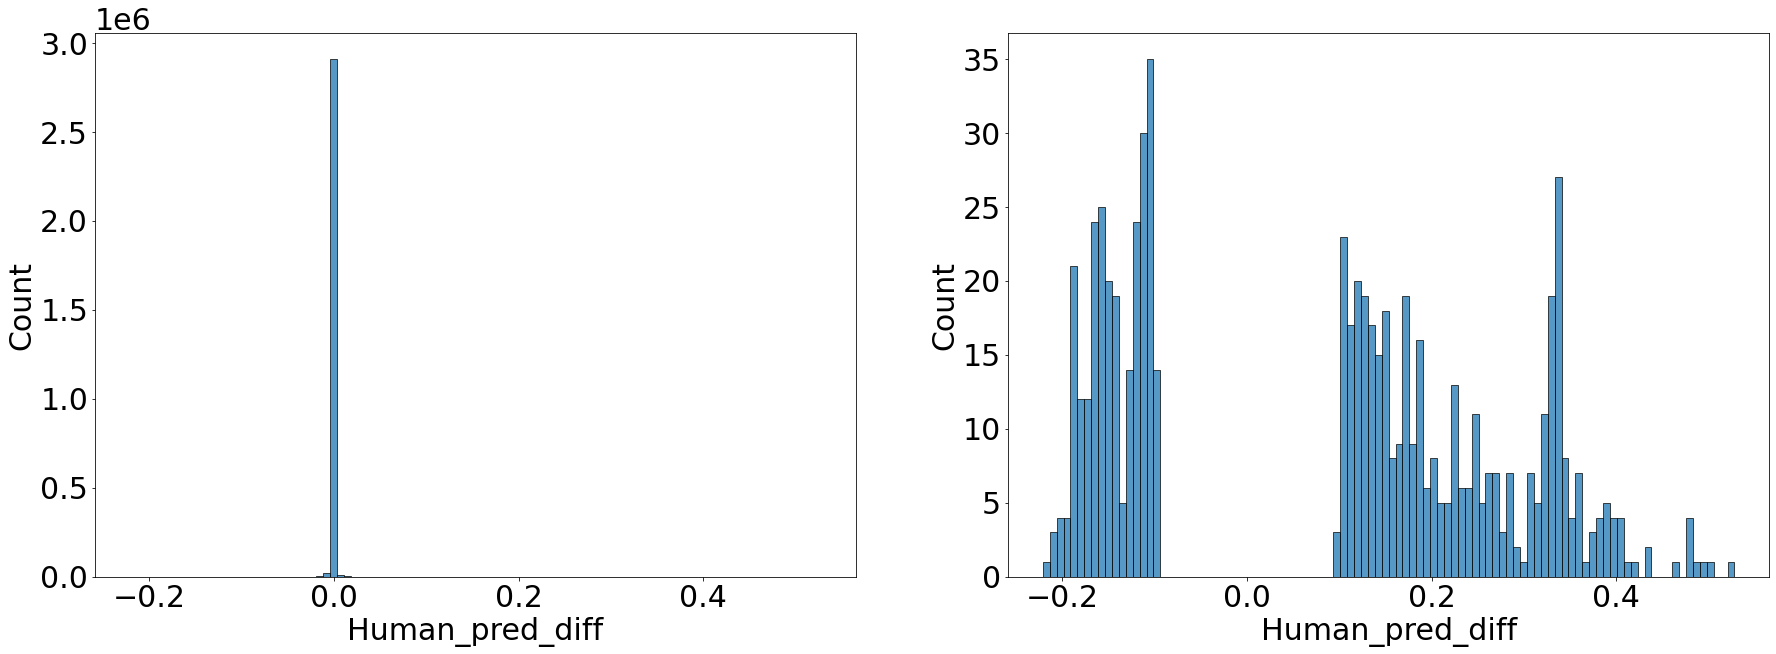

In [19]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

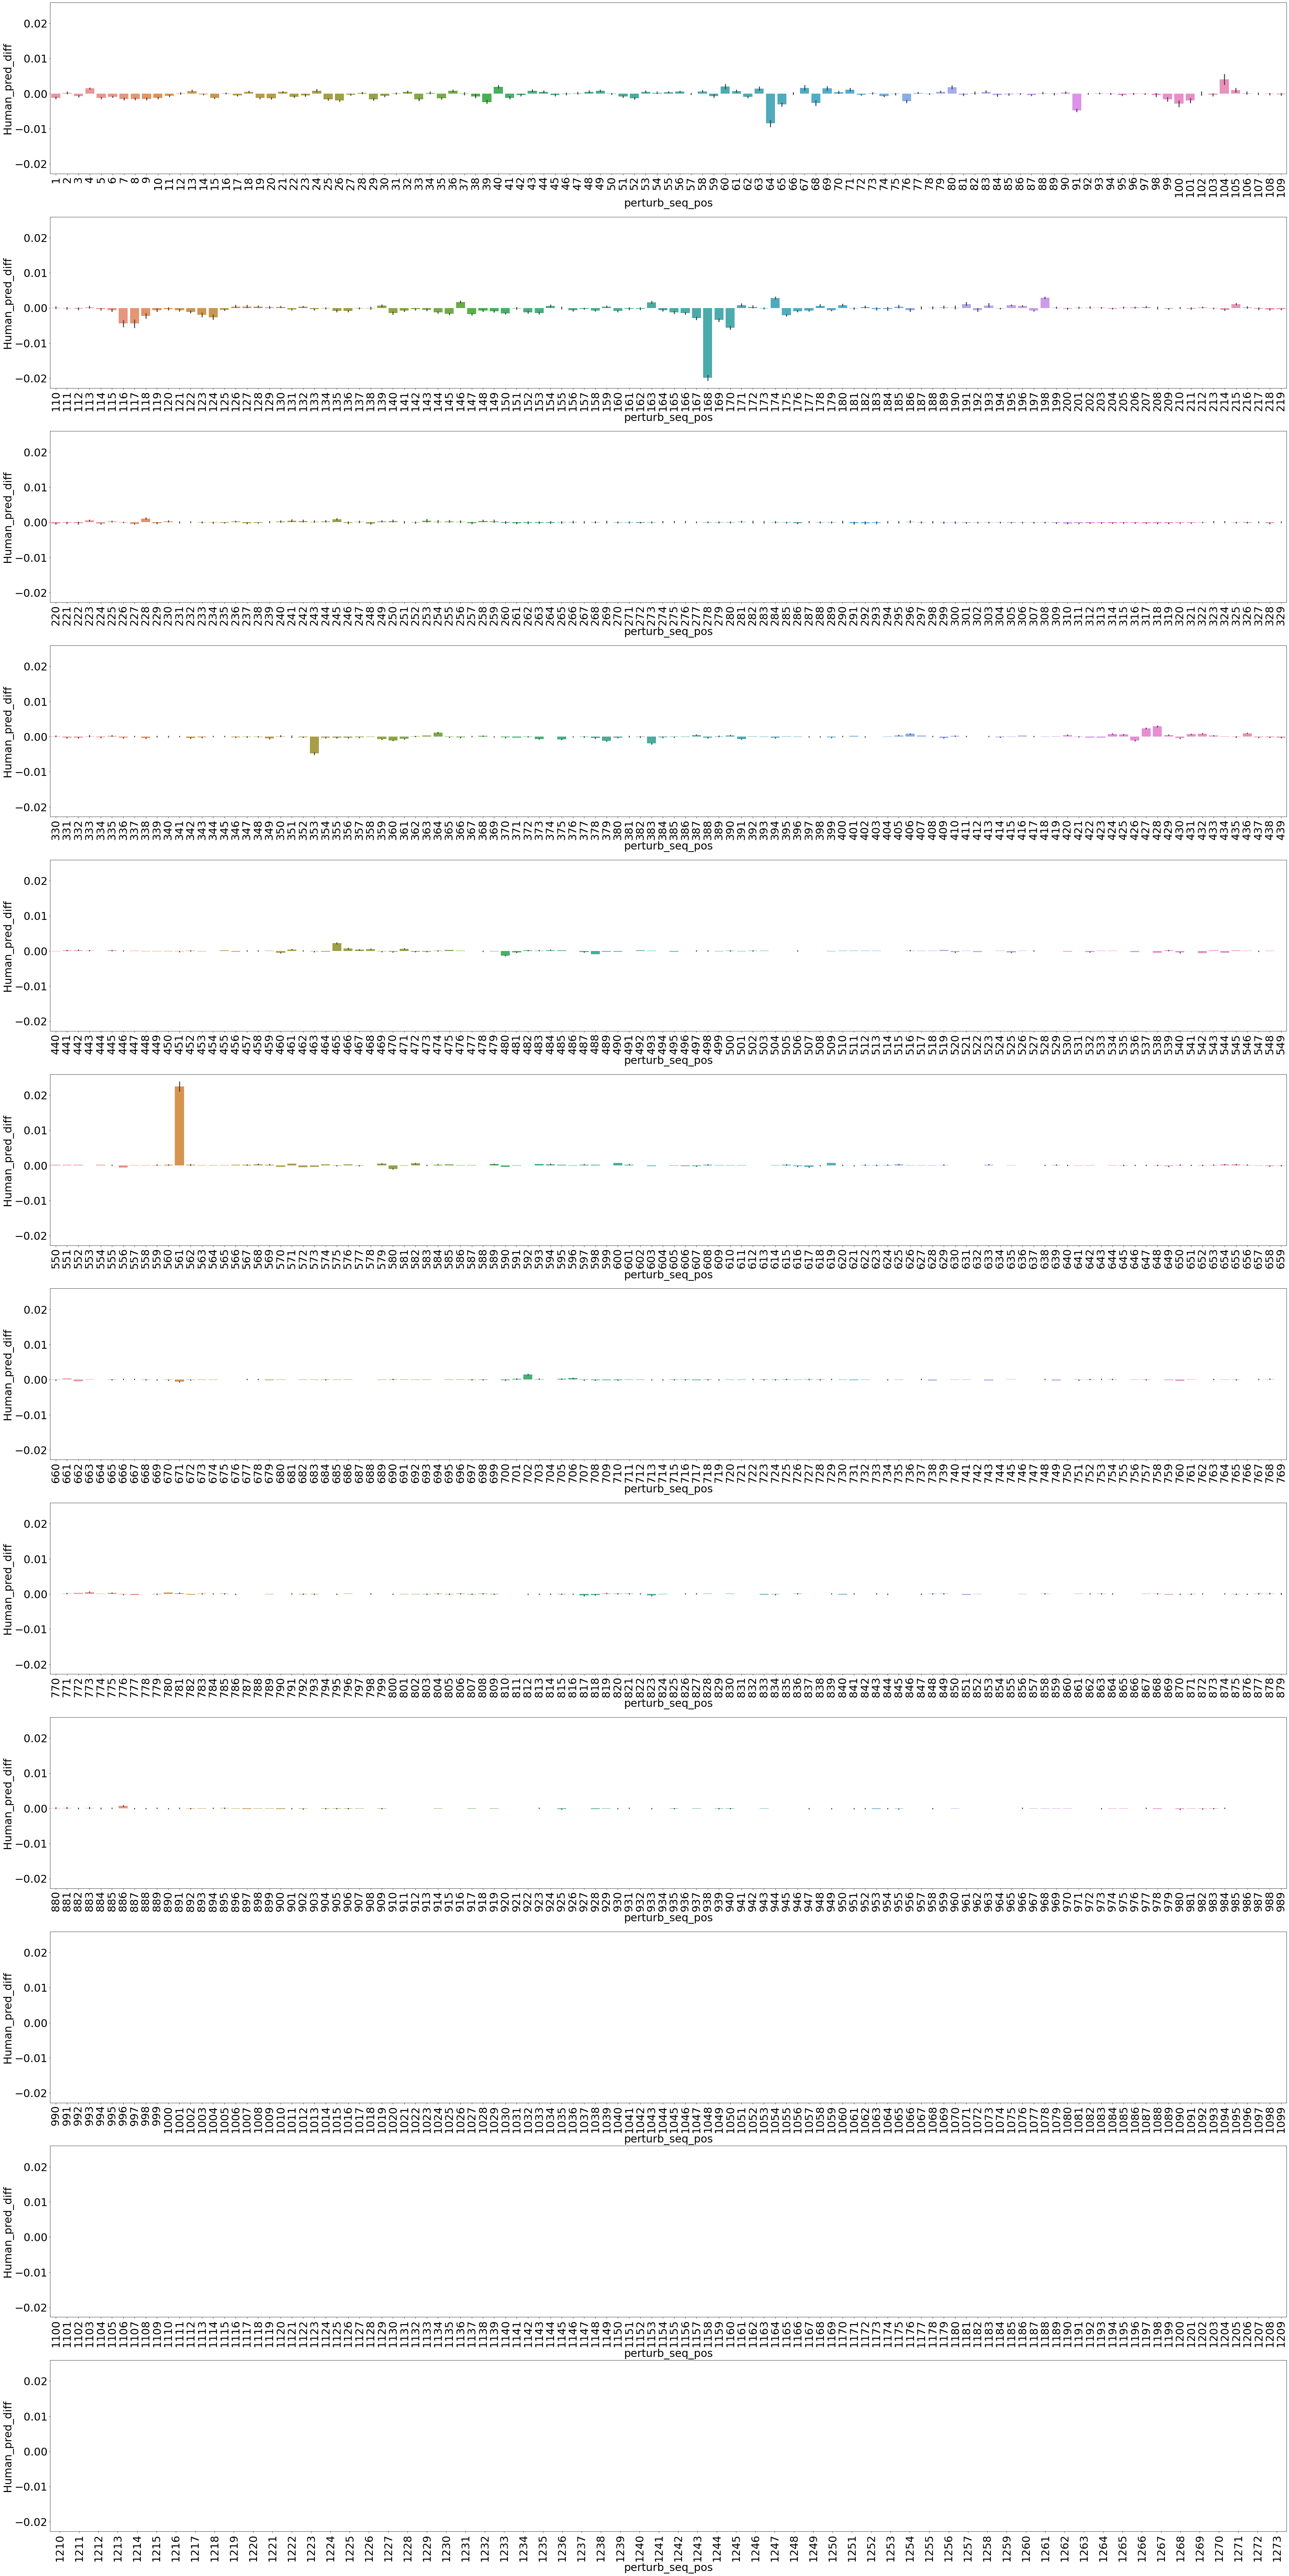

In [20]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

In [21]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
1,0.000021,0.000416,0.023190,0.000002,0.000055,0.000033,0.945324,0.030958,UniRef90_A0A7T6Y5W2,Human,G,1502,C,0.000613,0.000613,Human,Human,545
3,0.000021,0.000405,0.023336,0.000002,0.000056,0.000034,0.944569,0.031576,UniRef90_A0A7T6Y5W2,Human,V,1448,E,-0.000142,0.000142,Human,Human,524
7,0.000021,0.000403,0.023444,0.000002,0.000056,0.000034,0.944509,0.031530,UniRef90_A0A7T6Y5W2,Human,M,1947,K,-0.000201,0.000201,Human,Human,900
8,0.000021,0.000410,0.023263,0.000002,0.000056,0.000034,0.944561,0.031653,UniRef90_A0A7T6Y5W2,Human,K,1896,H,-0.000150,0.000150,Human,Human,854
9,0.000021,0.000410,0.023086,0.000002,0.000056,0.000034,0.945048,0.031343,UniRef90_A0A7T6Y5W2,Human,K,1896,C,0.000338,0.000338,Human,Human,854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31815,0.000017,0.000386,0.019084,0.000002,0.000047,0.000023,0.953408,0.027034,UniRef90_A0A8B1K2U2,Human,S,2000,F,0.000001,0.000001,Human,Human,939
31818,0.000017,0.000386,0.019148,0.000002,0.000047,0.000023,0.953345,0.027032,UniRef90_A0A8B1K2U2,Human,S,1686,Z,-0.000061,0.000061,Human,Human,689
31821,0.000017,0.000386,0.019120,0.000002,0.000047,0.000023,0.953430,0.026975,UniRef90_A0A8B1K2U2,Human,G,1899,J,0.000024,0.000024,Human,Human,857
31822,0.000017,0.000386,0.019142,0.000002,0.000047,0.000023,0.953347,0.027035,UniRef90_A0A8B1K2U2,Human,S,1669,B,-0.000059,0.000059,Human,Human,673


### Cut-off: mean=0 and variance=0

In [22]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

1017

<Figure size 432x288 with 0 Axes>

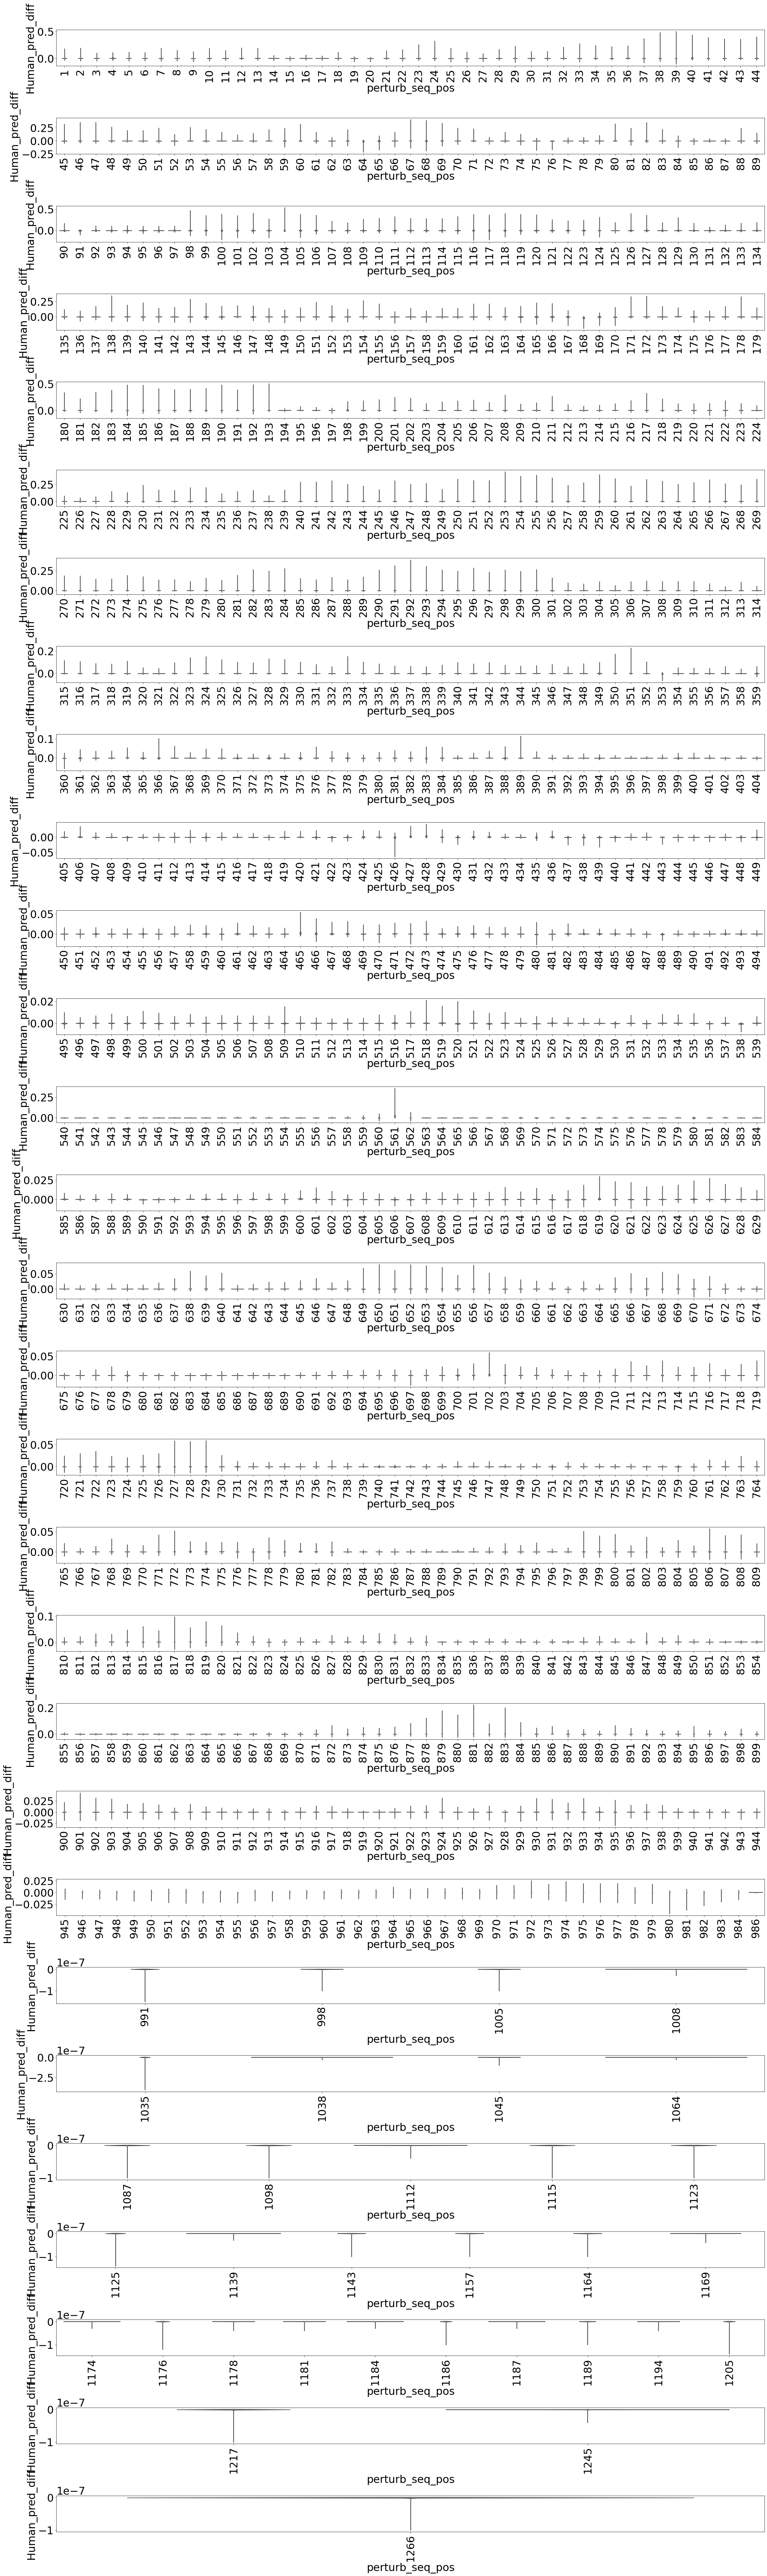

In [23]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(29, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 1273, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [24]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1017
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 305
1 intersection 2: 305
1 minus 2: 712
2 minus 1: 0
is 2 subset of 1: True


In [25]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

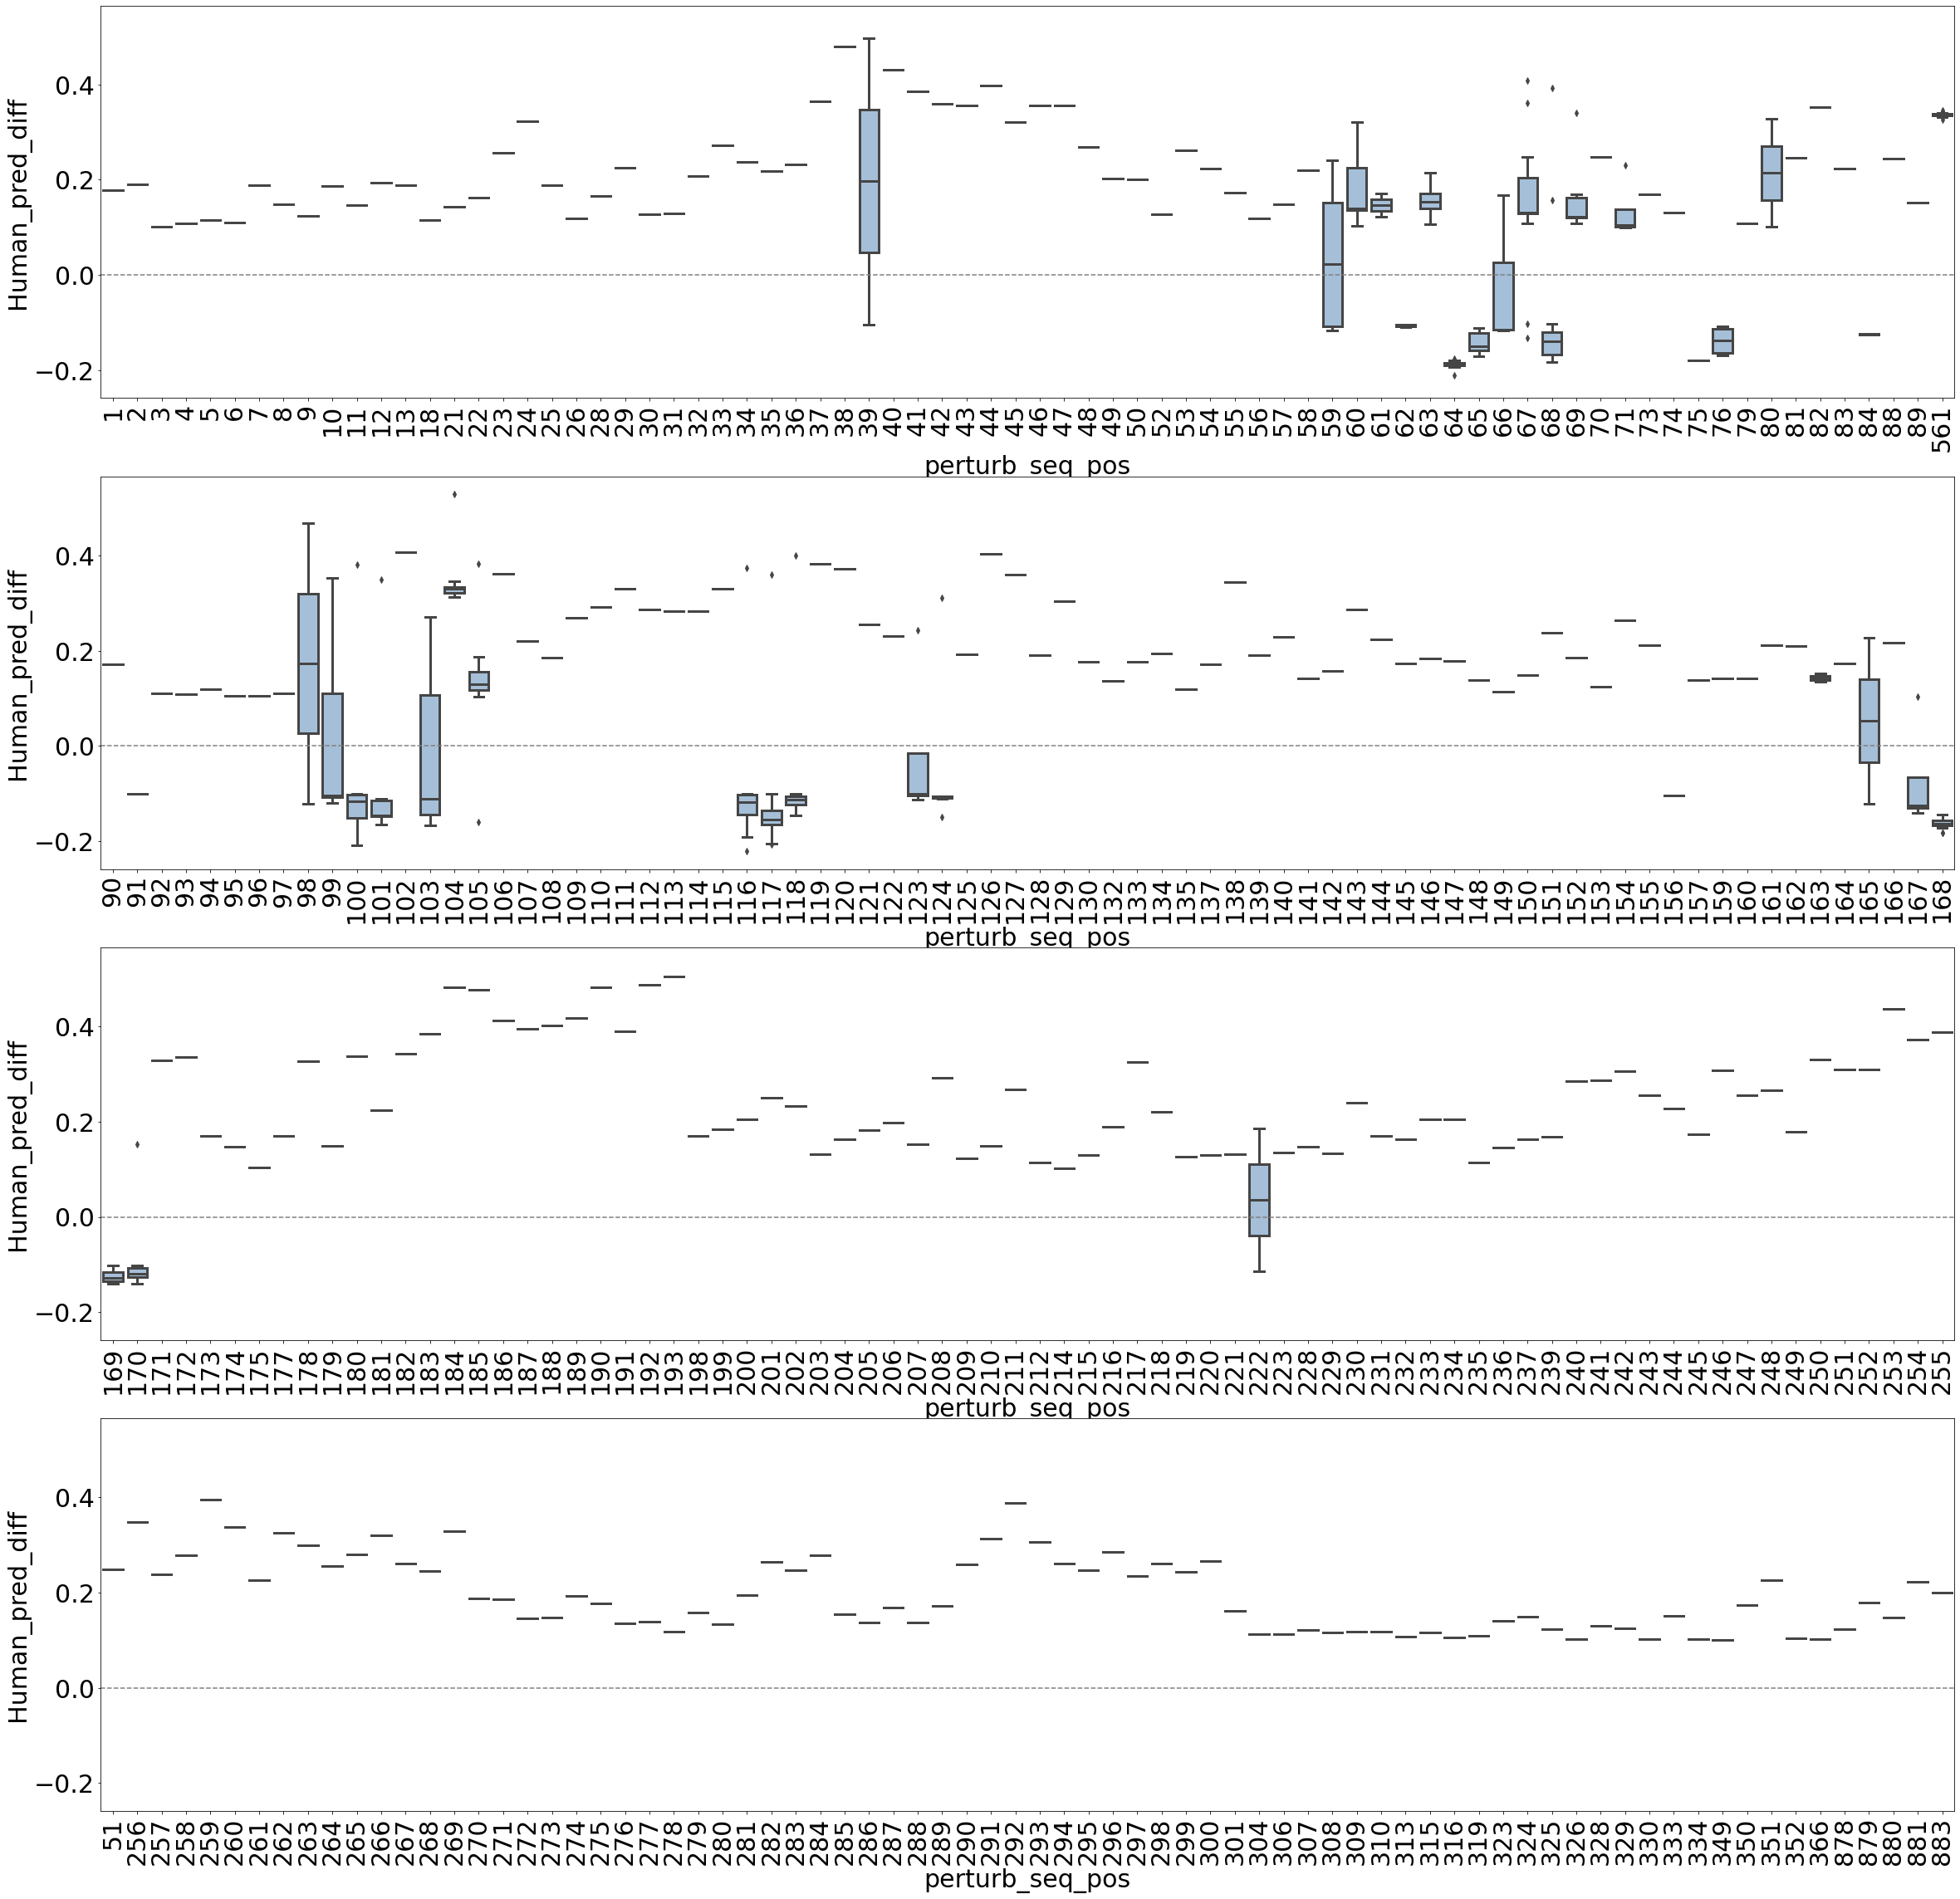

In [26]:
plt.clf()
fig, axs = plt.subplots(4, 1, figsize=(40, 40), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), 4)

for i in range(4):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")

plt.show()


### Important positions causing class change from Human

0
nan


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 432x288 with 0 Axes>

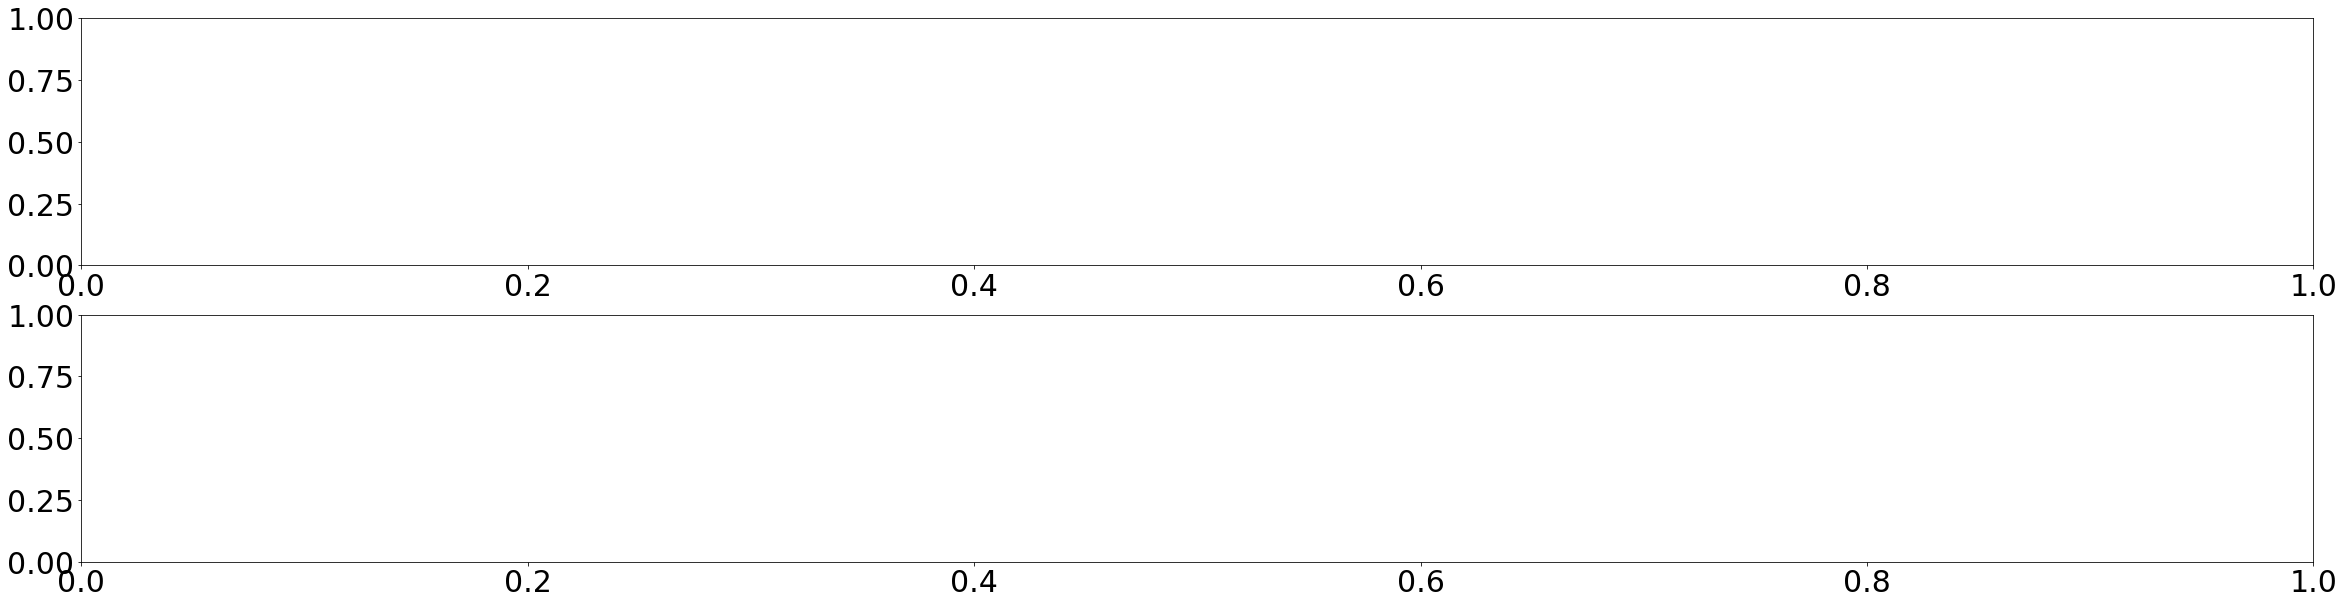

In [27]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 10), sharey=True)
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

sns.heatmap(data=df[df["perturb_seq_pos"] <=250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[0], vmax=max_val)
wrap_yticklabels(axs[0], label_width=10, break_long_words=True)
axs[0].tick_params(axis='x', rotation=90)


sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

In [ ]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(40, 5))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest")
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [ ]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

In [ ]:
#!pip install textalloc


In [ ]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [ ]:
annotate_df

### Mutations with new token NOT = X

In [ ]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

In [ ]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [ ]:
cut_off_df_2["perturbation_id"].nunique()

In [ ]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(6, 1, figsize=(50, 60), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), 6)

j = 0
for i in range(6):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [ ]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

In [ ]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

In [ ]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

In [ ]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [ ]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

In [ ]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()